# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)


В датасете 16 столбцов, проверим данные на дубликаты, аномальные значения и обработаем пропуски.

In [ ]:
data.duplicated().sum()

4

In [ ]:
data = data.drop_duplicates()

Проверим количественные признаки на аномалии, начнем с года регистрации.

In [ ]:
data['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Так как год регистрации автомобиля не может быть позже последней даты скачивания анкеты из базы, проверим ее.

In [ ]:
last_date = pd.to_datetime(data['DateCrawled'])
last_date.max()

Timestamp('2016-04-07 14:36:58')

In [ ]:
data = data.query('1910 < RegistrationYear < 2017')

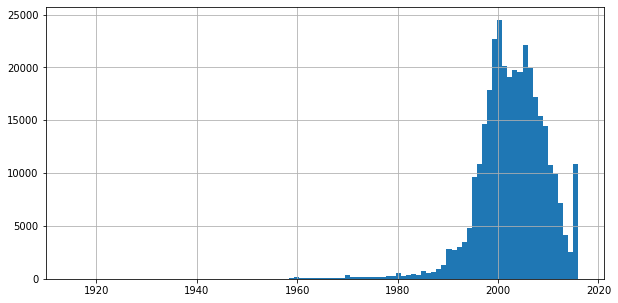

In [ ]:
data['RegistrationYear'].hist(bins=100, figsize = (10,5))

Опираясь на график и последнюю дату скачивания анкеты из базы, сохраним в датасете значения года регистрации автомобиля начиная с 1960 по 2016.

In [ ]:
data = data.query('1959 < RegistrationYear < 2017')

Перейдем к столбцу Power, мощности. Возьмем 2000 л.с. как максимальное значение и проверим распределение на гистограмме.

In [ ]:
data = data.query('Power < 2000')

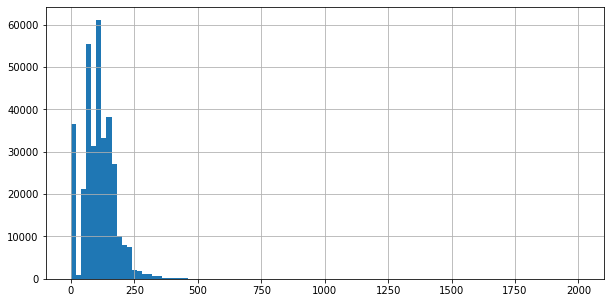

In [ ]:
data['Power'].hist(bins=100, figsize = (10,5))

Исходя из графика, удалим выбросы и установим правую границу в 500 л.с. 

Также можно заметить, что есть значения, равные 0 л.с., удалим их.

In [ ]:
data = data.query('0 < Power < 500')

Проверим столбец цены.

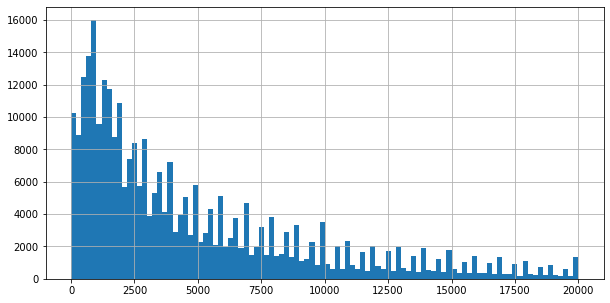

In [ ]:
data['Price'].hist(bins=100, figsize = (10,5))

In [ ]:
data['Price'].value_counts()

0        6384
500      4469
1500     4430
1200     3735
2500     3705
         ... 
3933        1
10328       1
456         1
605         1
8188        1
Name: Price, Length: 3591, dtype: int64

Среди цен имеются нулевые значения. Так как признак целевой, восстанавливать значения не будем, удалим их.

In [ ]:
data = data.query('0 < Price')

Некоторые из столбцов не содержат данных об автомобиле, поэтому не являются важными и не нужны для модели. Таким образом, удалим из датасета дату скачивания анкеты из базы, месяц регистрации автомобиля, дату создания анкеты, почтовый индекс владельца, количество фотографий автомобиля и дату последней активности пользователя.

In [ ]:
data = data.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures'])

Начнем обработку пропусков. 

In [ ]:
data.isnull().sum()

Price                   0
VehicleType         11036
RegistrationYear        0
Gearbox              5370
Power                   0
Model               11139
Kilometer               0
FuelType            15551
Brand                   0
NotRepaired         42889
dtype: int64

Так как мы не знаем причину пропусков в столбцах VehicleType и Model, введем категорию "unknown" (неизвестно).

In [ ]:
data['VehicleType'] = data['VehicleType'].fillna(value="unknown")

In [ ]:
data['Model'] = data['Model'].fillna(value="unknown")

В столбце *NotRepaired* заменим пустые значения на *no*, так как скорее всего люди не заполнили данное поле, потому что не чинили машину. Также переведем данный столбец в булев тип, заменив *yes* (чинилась) на 1, *no* (не чинилась) на 0.

In [ ]:
data['NotRepaired'] = data['NotRepaired'].fillna(value="no")

In [ ]:
data['NotRepaired'] = data['NotRepaired'].map({'yes':1, 'no':0}).astype(int)

Заменим пропущенные значения стобцов типа топлива и коробки передач на моду, сгруппировав данные по марке и модели автомобиля.

Данные в столбце *Gearbox* переведем в булев тип, заменив auto (автомат) на 1, manual (механика) на 0.

In [ ]:
data['FuelType']= data.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0])))

In [ ]:
data['Gearbox']= data.groupby(['Brand', 'Model'])['Gearbox'].transform(lambda x: x.fillna((x.mode()[0])))

In [ ]:
data['Gearbox'] = data['Gearbox'].map({'auto':1, 'manual':0}).astype(int)

In [ ]:
data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

In [ ]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296319 entries, 1 to 354368
Data columns (total 10 columns):
Price               296319 non-null int64
VehicleType         296319 non-null object
RegistrationYear    296319 non-null int64
Gearbox             296319 non-null int64
Power               296319 non-null int64
Model               296319 non-null object
Kilometer           296319 non-null int64
FuelType            296319 non-null object
Brand               296319 non-null object
NotRepaired         296319 non-null int64
dtypes: int64(6), object(4)
memory usage: 24.9+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,0,190,unknown,125000,gasoline,audi,1
2,9800,suv,2004,1,163,grand,125000,gasoline,jeep,0
3,1500,small,2001,0,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,0,69,fabia,90000,gasoline,skoda,0
5,650,sedan,1995,0,102,3er,150000,petrol,bmw,1


В данном шаге:
- была изучена таблица;
- проверены дубликаты;
- обработаны аномальные значения;
- обработаны пропущенные значения.

## Обучение моделей

Рассмотрим четыре модели:
- LinearRegression
- DecisionTreeRegressor
- CatBoost
- LightGBM

Модели CatBoost и LightGBM работают с категориальными данными, только для модели LightGBM приведем категориальные признаки к формату *category*. Для остальных преобразуем признаки техникой One-Hot Encoding и стандартизируем их.

In [ ]:
categorical = ['Brand','Model','VehicleType','FuelType']

In [ ]:
target = data['Price']
features = data.drop('Price', axis=1)

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

In [ ]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [ ]:
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop('Price', axis=1)

In [ ]:
features_tr_ohe, features_val_ohe, target_tr_ohe, target_valid_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.2, random_state=12345)
features_tr_ohe, features_test_ohe, target_tr_ohe, target_test_ohe = train_test_split(
    features_tr_ohe, target_tr_ohe, test_size=0.25, random_state=12345)

In [ ]:
numeric = ['Power','Kilometer','RegistrationYear']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_tr_ohe[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
features_tr_ohe[numeric] = scaler.transform(features_tr_ohe[numeric])
features_val_ohe[numeric] = scaler.transform(features_val_ohe[numeric]) 
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric]) 

### LinearRegression

In [ ]:
lin = LinearRegression()

In [ ]:
%%time
lin.fit(features_tr_ohe,target_tr_ohe)

CPU times: user 11 s, sys: 3.76 s, total: 14.8 s
Wall time: 14.9 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
%%time
predictions_valid = lin.predict(features_val_ohe)
print('RMSE модели линейной регрессии:', mean_squared_error(target_valid_ohe, predictions_valid)**0.5)

RMSE модели линейной регрессии: 2573.820828273601
CPU times: user 45.6 ms, sys: 104 ms, total: 149 ms
Wall time: 119 ms


### DecisionTreeRegressor

In [ ]:
dec_tree = DecisionTreeRegressor(random_state=12345)

In [ ]:
%%time

parameters = {'max_depth': range (1,10)}

clf = GridSearchCV(dec_tree, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)

clf.fit(features_tr_ohe,target_tr_ohe)

print('Параметры:', clf.best_params_)

Параметры: {'max_depth': 9}
CPU times: user 1min 14s, sys: 8.73 s, total: 1min 22s
Wall time: 1min 22s


In [ ]:
%%time
predictions_valid = clf.predict(features_val_ohe)

print('RMSE модели дерева решений:', mean_squared_error(target_valid_ohe, predictions_valid)**0.5)

RMSE модели дерева решений: 2025.6691409930963
CPU times: user 54.8 ms, sys: 49 ms, total: 104 ms
Wall time: 106 ms


### CatBoost

In [ ]:
cat = CatBoostRegressor(random_state = 12345)

In [ ]:
%%time

cat.fit(features_train, target_train, cat_features=categorical, verbose = False)

CPU times: user 4min 18s, sys: 38.4 s, total: 4min 56s
Wall time: 4min 58s


In [ ]:
%%time
predictions_valid = cat.predict(features_valid)

print('RMSE модели CatBoost:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели CatBoost: 1643.4339381851953
CPU times: user 350 ms, sys: 54.1 ms, total: 405 ms
Wall time: 377 ms


### LightGBM

In [ ]:
lgbm = LGBMRegressor(random_state = 12345)

In [ ]:
features_train[categorical] = features_train[categorical].astype('category')
features_valid[categorical] = features_valid[categorical].astype('category')
features_test[categorical] = features_test[categorical].astype('category')

In [ ]:
%%time

lgbm.fit(features_train, target_train)

CPU times: user 1min 7s, sys: 1.25 s, total: 1min 8s
Wall time: 1min 8s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
%%time
predictions_valid = lgbm.predict(features_valid)

print('RMSE модели LightGBM:', mean_squared_error(target_valid, predictions_valid)**0.5)

RMSE модели LightGBM: 1614.5344097266689
CPU times: user 564 ms, sys: 0 ns, total: 564 ms
Wall time: 509 ms


В данном шаге были обучены и проверены на валидационной выборке четыре модели: LinearRegression, DecisionTreeRegressor, CatBoost, LightGBM. 

Получили значения:
- модель LightGBM со значением RMSE - 1614, скоростью обучения - 7.06 с и скоростью предсказания - 0.597 с;
- модель CatBoost со значением RMSE - 1643, скоростью обучения - 307 с и скоростью предсказания - 0.357 с;
- модель DecisionTree со значением RMSE - 2026, скоростью обучения - 83 с и скоростью предсказания - 0.103 с;
- модель LinearRegression со значением RMSE - 2574, скоростью обучения - 15.4 с и скоростью предсказания - 0.12 с.

## Анализ моделей

Проверим модели на тестовой выборке.

In [ ]:
%%time

#LinearRegression

predictions_test = lin.predict(features_test_ohe)
print('RMSE модели линейной регрессии:', mean_squared_error(target_test_ohe, predictions_test)**0.5)

RMSE модели линейной регрессии: 2591.755594001532
CPU times: user 57.4 ms, sys: 38.3 ms, total: 95.7 ms
Wall time: 95.3 ms


In [ ]:
%%time

#DecisionTreeRegressor

predictions_test = clf.predict(features_test_ohe)
print('RMSE модели дерева решений:', mean_squared_error(target_test_ohe, predictions_test)**0.5)

RMSE модели дерева решений: 2028.8337457673226
CPU times: user 62.3 ms, sys: 66.6 ms, total: 129 ms
Wall time: 193 ms


In [ ]:
%%time

#CatBoost

predictions_test = cat.predict(features_test)
print('RMSE модели CatBoost:', mean_squared_error(target_test, predictions_test)**0.5)

RMSE модели CatBoost: 1656.9959712725129
CPU times: user 297 ms, sys: 12.5 ms, total: 309 ms
Wall time: 303 ms


In [ ]:
%%time 

#LightGBM

predictions_test = lgbm.predict(features_test)
print('RMSE модели LightGBM:', mean_squared_error(target_test, predictions_test)**0.5)

RMSE модели LightGBM: 1624.292763764323
CPU times: user 577 ms, sys: 0 ns, total: 577 ms
Wall time: 591 ms


На тестовой выборке получили такие же результаты, как и на валидационной.

## Общий вывод

Модели градиентного бустинга показали результаты лучше чем модели линейной регрессии и дерева решений. Наиболее точной оказалась модель LightGBMRegressor и после CatBoostRegressor. При этом модели LinearRegression и DecisionTreeRegressor быстрее моделей градиентного бустинга. Полученные результаты:

RMSE метрика:
- LightGBM: 1614;
- CatBoost: 1643;
- DecisionTree: 2026;
- LinearRegression: 2574.

Скорость обучения:
- LightGBM: 7.06 с;
- CatBoost: 307 с;
- DecisionTree: 83 с;
- LinearRegression: 15.4 с.

Скорость предсказания на тестовой выборке:
- LightGBM: 0.5 с;
- CatBoost: 0.3 с;
- DecisionTreeRegressor: 0.09 с;
- LinearRegression: 0.06 с.